23/12/12 00:58:55 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-5d92e5b1-0d4b-4557-ab48-0e27526a057a. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
23/12/12 00:58:55 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


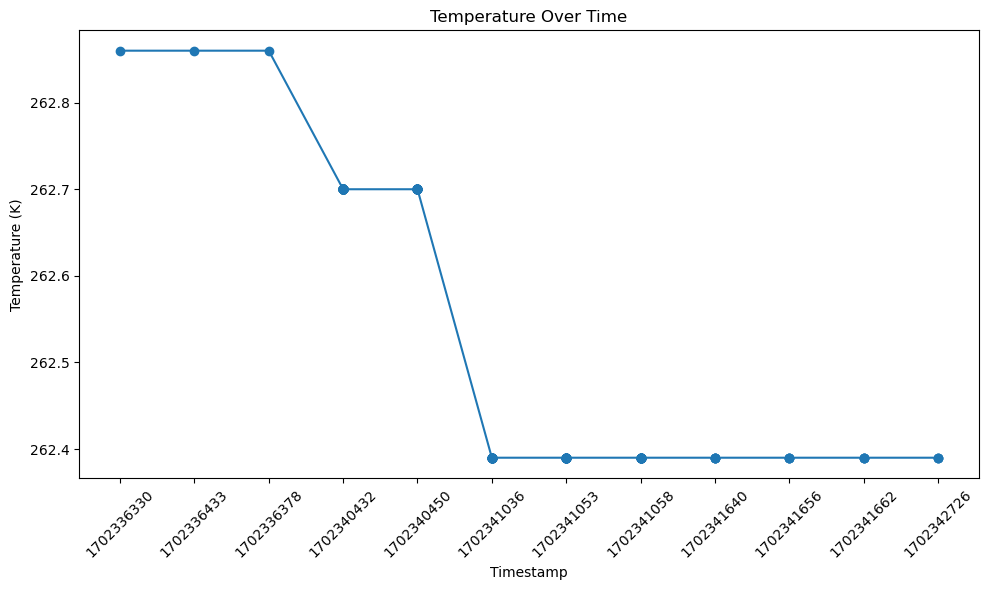

In [ ]:
import json
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import StructType, StructField, StringType, DoubleType
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time

#spark session
spark = SparkSession.builder \
    .appName("TemperatureVisualization") \
    .getOrCreate()

#defining the schema
schema = StructType([
    StructField("coord", StructType([
        StructField("lon", DoubleType(), True),
        StructField("lat", DoubleType(), True),
    ]), True),
    StructField("main", StructType([
        StructField("temp", DoubleType(), True),
        StructField("feels_like", DoubleType(), True),
    ]), True),
    StructField("dt", StringType(), True),
])


static_data = spark.read.format("json").schema(schema).load("final_project/data.json") #read a static DataFrame to infer the schema

#use the inferred schema for the streaming DataFrame
streaming_data = spark.readStream \
    .format("json") \
    .schema(schema) \
    .option("maxFilesPerTrigger", 1)\
    .load("final_project")

#extracting the temperature data
temperature_data = streaming_data.select("dt", "main.temp")

#streaming queiry
query = temperature_data.writeStream \
    .outputMode("append") \
    .foreachBatch(lambda df, epoch_id: plot_temperature(df)) \
    .start()

#function to plot temperature data
def plot_temperature(df):
    df_pandas = df.toPandas()
    
    plt.figure(figsize=(10, 6))
    plt.plot(df_pandas["dt"], df_pandas["temp"], marker='o')
    plt.title("Temperature Over Time")
    plt.xlabel("Timestamp")
    plt.ylabel("Temperature (K)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

#for continous display of the data over time as data comes into the json file
while True:
    time.sleep(5)  #micro batches
